# This notebook will show different ways to work with videos using Python.

Run this next line to confirm your camera device is attached.
You should get output similar to: crw-rw---- 1 root video 81, 0 Jun 30 02:30 /dev/video0


In [1]:
!ls -ltrh /dev/video*

crw-rw---- 1 root video 81, 1 Oct  1 00:26 /dev/video1
crw-rw---- 1 root video 81, 0 Oct  1 00:26 /dev/video0


### Common Camera errors:
- Your camera is not connected
- For remote containers, you did not add the parameter to attach your device. Stop the container and run again with the required parameter to attach your camera:
-- E.G. sudo docker run --runtime nvidia -it --rm --network host ***--device /dev/video0***  dustynv/l4t-ml:r32.5.0-py3
-If this is a windows machine, typically your primary camera will be device 0 (e.g.  cv2.VideoCapture(0) ) but if it is a USB camera and you have an embedded camera, it may be device 1. You can always set the value in the USBcamera class to cv.VideoCapture(1) and test it out.

### Capturing camera feeds from local session
This next session should ***not be using a remote headless connection and JupyterLab on the nano.***  
It can be run locally if using a monitor and keyboard on Ubuntu or Windows.

In [2]:
# #Code adapted from book, Programming Computer Vision with Python
# #this code is just for reference only, do not run this on your nano, just your host machine
# import cv2

# clicked = False
# def onMouse(event, x, y, flags, param):
#     global clicked
#     if event == cv2.EVENT_LBUTTONUP:
#         clicked = True

# cameraCapture = cv2.VideoCapture(1)
# cv2.namedWindow('MyCamera')
# cv2.setMouseCallback('MyCamera', onMouse)

# print ('Showing camera feed in another window. Press any key to stop.')
# success, frame = cameraCapture.read()
# while cv2.waitKey(1) == -1 and not clicked:
#     if frame is not None:
#         cv2.imshow('MyCamera', frame)
#         #display(Image.fromarray(img3))
#     success, frame = cameraCapture.read()

# cv2.destroyWindow('MyCamera')

[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (935) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


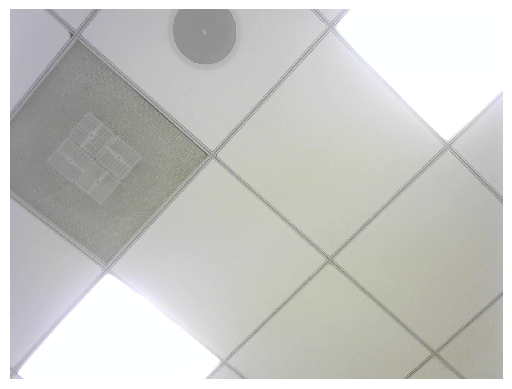

In [3]:
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture(0)   # or 1
ret, frame = cap.read()
cap.release()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### Capturing camera feeds from your Jetson Nano
On the Nano, you can work with video by using pyWidgets to show the videos within the JupyterLab notebook. For convenience, we are use the classes and functions jetcam utilities but I have included the classes in the first code block.


In [4]:
#jetcam utilities  https://github.com/NVIDIA-AI-IOT/jetcam
#including classes here to reduce install when moving code between host machines and nano
import traitlets
import threading
import numpy as np
import cv2
import atexit


class Camera(traitlets.HasTraits):

    value = traitlets.Any()
    width = traitlets.Integer(default_value=224)
    height = traitlets.Integer(default_value=224)
    format = traitlets.Unicode(default_value='bgr8')
    running = traitlets.Bool(default_value=False)
    
    def __init__(self, *args, **kwargs):
        super(Camera, self).__init__(*args, **kwargs)
        if self.format == 'bgr8':
            self.value = np.empty((self.height, self.width, 3), dtype=np.uint8)
        self._running = False
            
    def _read(self):
        """Blocking call to read frame from camera"""
        raise NotImplementedError
        
    def read(self):
        if self._running:
            raise RuntimeError('Cannot read directly while camera is running')
        self.value = self._read()
        return self.value
    
    def _capture_frames(self):
        while True:
            if not self._running:
                break
            self.value = self._read()
            
    @traitlets.observe('running')
    def _on_running(self, change):
        if change['new'] and not change['old']:
            # transition from not running -> running
            self._running = True
            self.thread = threading.Thread(target=self._capture_frames)
            self.thread.start()
        elif change['old'] and not change['new']:
            # transition from running -> not running
            self._running = False
            self.thread.join()


def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

class USBCamera(Camera):
    
    capture_fps = traitlets.Integer(default_value=30)
    capture_width = traitlets.Integer(default_value=640)
    capture_height = traitlets.Integer(default_value=480)   
    capture_device = traitlets.Integer(default_value=0)
    
    def __init__(self, *args, **kwargs):
        super(USBCamera, self).__init__(*args, **kwargs)
        try:
            #self.cap = cv2.VideoCapture(self._gst_str(), cv2.CAP_GSTREAMER)
            self.cap = cv2.VideoCapture(0) #if on nano, change to 0

            re , image = self.cap.read()
            
            if not re:
                raise RuntimeError('Could not read image from camera.')
            
        except:
            raise RuntimeError(
                'Could not initialize camera.  Please see error trace.')

        atexit.register(self.cap.release)
                
    def _gst_str(self):
        return 'v4l2src device=/dev/video{} ! video/x-raw, width=(int){}, height=(int){}, framerate=(fraction){}/1 ! videoconvert !  video/x-raw, format=(string)BGR ! appsink'.format(self.capture_device, self.capture_width, self.capture_height, self.capture_fps)
    
    def _read(self):
        re, image = self.cap.read()
        if re:
            image_resized = cv2.resize(image,(int(self.width),int(self.height)))
            return image_resized
        else:
            raise RuntimeError('Could not read image from camera')


In [5]:
#adapted from the Hello Camera lab from Getting Started with AI on the Jetson
#from jetcam.usb_camera import USBCamera

#TODO change capture_device if incorrect for your system
camera = USBCamera(width=224, height=224, capture_width=640, capture_height=480, capture_device=0)

image = camera.read()

print(image.shape)

(224, 224, 3)


[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (935) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


### use Ipywidgets to display the image captured from the camera feed
this code is adapted from: https://github.com/QuantStack/quantstack-talks/blob/master/2018-11-14-PyParis-widgets/notebooks/1.ipywidgets.ipynb

This first code block will create a widget and update it with one image from the camera.

If the widget does not display but you do not get an error message, just a binary value then you most likely need to install node.js and ipywidgets for JupyerLab, bind the ipwidgets and then refresh or restart your JupyterLab session.  Follow the instructions here for your host machine: https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0.

If you are experiencing this on the nano, you should make sure you have the latest image and container recommended by your instructor.

In [6]:
import ipywidgets
from IPython.display import display
#import bgr8_to_jpeg

image_widget = ipywidgets.Image(format='jpeg')

#this is using the image defined in the previous code block that is reading the camera stream
#reading one image
image_widget.value = bgr8_to_jpeg(image)

display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

To display the full video stream, we need to update the camera feed for video.

In [7]:
camera.running = True

def update_image(change):
    image = change['new']
    image_widget.value = bgr8_to_jpeg(image)
    
camera.observe(update_image, names='value')

To stop the video feed:

In [8]:
camera.unobserve(update_image, names='value')

### Transform the images from the camera feed to gray - CPU
Lets first try using OpenCV without using CUDA

In [9]:
#lets transform the image
camera.running = True

def update_image(change):
    image = change['new']
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image_widget.value = bgr8_to_jpeg(gray)
    
camera.observe(update_image, names='value')



### Transform the images from the camera feed to gray - GPU
Now let's use OpenCV CUDA
Note the extra steps required to first upload the images to the GPU, process them and then download the images back to the CPU

In [10]:
#lets transform the image the CUDA way
camera.running = True

def update_image(change):
    image = change['new']
    gpu_frame = cv2.cuda_GpuMat()
    gpu_frame.upload(image)
    gpu_gray = cv2.cuda.cvtColor(gpu_frame, cv2.COLOR_BGR2GRAY)
    gray = gpu_gray.download()
    image_widget.value = bgr8_to_jpeg(gray)

    
camera.observe(update_image, names='value')

In [11]:
camera.unobserve(update_image, names='value')

### Next we are going to directly read in a video file
We will again use the Video library of ipwidgets rather than the jetcam utilities.  
The video in this example should be an MP4 video. 
The code below will create a widget and play the file.

In [12]:
from IPython.display import display
from ipywidgets import Video, Image
import numpy as np
import base64

video = Video.from_file('hallway.mp4')
video


Video(value=b'\x00\x00\x00\x14ftypmp42\x00\x00\x02\x00mp42\x00\x00\x00\x08free\x00\x1b50mdat\x00\x00\x00\x00..…

Let's apply a cv2 Canny transformation

In [13]:
import cv2
cap = cv2.VideoCapture('hallway.mp4')

frames = []

while(1):
    try:
        _, frame = cap.read()

        #fgmask = cv2.Canny(frame, 100, 100)
        fgmask = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        mask = fgmask > 100
        frame[mask, :] = 0

        frames.append(frame)
    except Exception:
        break

width = int(cap.get(3))
height = int(cap.get(4))

filename = 'output.mp4'

fourcc = cv2.VideoWriter_fourcc(*'avc1')
writer = cv2.VideoWriter(filename, fourcc, 25, (width, height))

for frame in frames:
    writer.write(frame)

cap.release()
writer.release()

with open(filename, 'rb') as f:
    video.value = f.read()

In [14]:
# # -*- coding: utf-8 -*-
# """
# Created on Mon Aug 13 12:15:39 2018

# @author: bhaumik
# """

# import pycuda.driver as drv
# from pycuda.compiler import SourceModule
# import numpy as np
# import cv2
# import pycuda.autoinit

# mod = SourceModule \
#     (
#         """
# #include<stdio.h>
# #define INDEX(a, b) a*256+b

# __global__ void bgr2gray(float *d_result,float *b_img, float *g_img, float *r_img)
# {
# unsigned int idx = threadIdx.x+(blockIdx.x*(blockDim.x*blockDim.y));

# unsigned int a = idx/256;
# unsigned int b = idx%256;
# d_result[INDEX(a, b)] = (0.299*r_img[INDEX(a, b)]+0.587*g_img[INDEX(a, b)]+0.114*b_img[INDEX(a, b)]);

# }
  
#   """
#       )

# cap = cv2.VideoCapture(0)
# bgr2gray = mod.get_function("bgr2gray")
# while(True):
#     # Capture frame-by-frame
#     ret, h_img = cap.read()
#     h_img = cv2.resize(h_img,(256,256),interpolation = cv2.INTER_CUBIC)

#     b_img = h_img[:, :, 0].reshape(65536).astype(np.float32)
#     g_img = h_img[:, :, 1].reshape(65536).astype(np.float32)
#     r_img = h_img[:, :, 2].reshape(65536).astype(np.float32)
#     h_result=r_img
   
#     bgr2gray(drv.Out(h_result), drv.In(b_img), drv.In(g_img),drv.In(r_img),block=(1024, 1, 1), grid=(64, 1, 1))

#     h_result=np.reshape(h_result,(256,256)).astype(np.uint8)
#     cv2.imshow("Grayscale Image",h_result)
    

#     # Display the resulting frame
#     cv2.imshow('Original frame',h_img)
#     if cv2.waitKey(50) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()



In [15]:
# -*- coding: utf-8 -*-
"""
CUDA BGR → Grayscale demo (Jetson / Docker / Jupyter friendly)
"""

import pycuda.driver as drv
from pycuda.compiler import SourceModule
import numpy as np
import cv2
import pycuda.autoinit
from matplotlib import pyplot as plt

# ---- CUDA kernel ----
mod = SourceModule(
    """
    #define INDEX(a,b) (a*256+b)
    __global__ void bgr2gray(float *d_result, float *b_img, float *g_img, float *r_img)
    {
        unsigned int idx = threadIdx.x + (blockIdx.x * blockDim.x * blockDim.y);
        unsigned int a = idx / 256;
        unsigned int b = idx % 256;
        if (idx < 256*256)
            d_result[INDEX(a,b)] = (0.299f*r_img[INDEX(a,b)] +
                                    0.587f*g_img[INDEX(a,b)] +
                                    0.114f*b_img[INDEX(a,b)]);
    }
    """
)
bgr2gray = mod.get_function("bgr2gray")

# ---- Open the first free camera ----
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Camera 0 busy or missing, trying 1…")
    cap = cv2.VideoCapture(1)

if not cap.isOpened():
    raise RuntimeError("No camera available")

while True:
    ret, h_img = cap.read()
    if not ret:
        print("No frame received")
        break

    # Resize to 256×256
    h_img = cv2.resize(h_img, (256, 256), interpolation=cv2.INTER_CUBIC)

    # Flatten and cast to float32
    b_img = h_img[:, :, 0].astype(np.float32).ravel()
    g_img = h_img[:, :, 1].astype(np.float32).ravel()
    r_img = h_img[:, :, 2].astype(np.float32).ravel()
    h_result = np.empty_like(r_img)

    # Launch kernel: 256*256 = 65536 threads
    bgr2gray(
        drv.Out(h_result), drv.In(b_img), drv.In(g_img), drv.In(r_img),
        block=(1024, 1, 1), grid=(64, 1, 1)
    )

    gray = h_result.reshape(256, 256).astype(np.uint8)

    # --- Display in Jupyter / headless ---
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(h_img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(gray, cmap='gray'); plt.title("CUDA Gray"); plt.axis('off')
    plt.show()

    # Optional: save frame to disk each loop (overwrites)
    cv2.imwrite("cuda_gray.jpg", gray)

    # Break after one frame (remove to run continuously)
    break

cap.release()


Camera 0 busy or missing, trying 1…
Unexpected exception formatting exception. Falling back to standard exception


[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (1760) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module v4l2src2 reported: Device '/dev/video0' is busy
[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (888) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (480) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0] global /opt/opencv/modules/videoio/src/cap_v4l.cpp (893) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (1760) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module v4l2src3 reported: Device '/dev/video1' is not a capture device.
[ WARN:0] global /opt/opencv/modules/videoio/src/cap_gstreamer.cpp (888) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0] global /opt/opencv

In [6]:
ls -ltrh /dev/video*


crw-rw---- 1 root video 81, 1 Sep 30 21:48 /dev/video1
crw-rw---- 1 root video 81, 0 Sep 30 21:48 /dev/video0


In [7]:
cap.release()
cv2.destroyAllWindows()

This next code block will close any open widgets.

In [8]:
from ipywidgets import Widget
Widget.close_all()

This next code block is a good idea to run before you move to another notebook to both release your camera if you ran the part of the code that uses your camera device and release available compute resources.

In [9]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}